In [1]:
import torch
import transformers
import os
import math
from transformers import pipeline
from transformers.image_utils import load_image
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)
os.environ['HF_HOME'] = MODEL_DIR

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = load_image(url)
print(image.size)

feature_extractor = pipeline(
    model="facebook/dinov3-vith16plus-pretrain-lvd1689m",
    task="image-feature-extraction",
)
features = feature_extractor(image)

(960, 686)


Device set to use cuda:0


In [2]:
features = torch.tensor(features)
features_no_batch = features.squeeze(0)

num_tokens = features_no_batch.shape[0]
num_patches_guess = int(math.sqrt(num_tokens))**2
h = w = int(math.sqrt(num_patches_guess))
num_special_tokens = num_tokens - num_patches_guess
patch_features = features_no_batch[num_special_tokens:, :]
patch_features = patch_features.numpy()

print(patch_features.shape)

(196, 1280)


(196, 1280) (196, 3) (14, 14, 3)


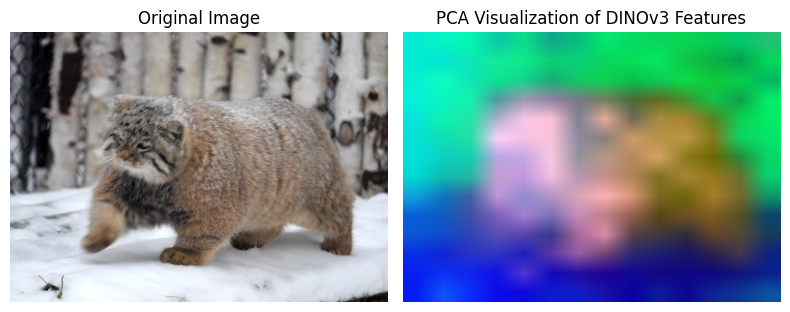

In [3]:
pca = PCA(n_components=3)
features_pca = pca.fit_transform(patch_features)

pca_image = features_pca.reshape((h, w, 3))
print(patch_features.shape, features_pca.shape, pca_image.shape)

pca_image_normalized = np.zeros_like(pca_image)
for i in range(3):
    channel = pca_image[:, :, i]
    pca_image_normalized[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min())

pca_pil_image = Image.fromarray((pca_image_normalized * 255).astype(np.uint8))

pca_pil_image_bilinear = pca_pil_image.resize(image.size, Image.Resampling.BILINEAR)

fig, axes = plt.subplots(1, 2, figsize=(8, 8))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# BILINEAR
axes[1].imshow(pca_pil_image_bilinear)
axes[1].set_title("PCA Visualization of DINOv3 Features")
axes[1].axis('off')

plt.tight_layout()
plt.show()